In [1]:
%autosave 0

Autosave disabled


In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from adam_wrangle import train_val_test
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from math import sqrt

SyntaxError: invalid syntax (evaluate.py, line 4)

Let's read in the diamonds csv from the explore lesson.

In [2]:
df = pd.read_csv('diamonds.csv', index_col=0)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


We have to split our data before we can fit a model to our data and generate some predictions.

In [3]:
train, val, test = train_val_test(df)
train.shape, val.shape, test.shape

((37758, 10), (8091, 10), (8091, 10))

Let's make X and y train series. Let's use carat, since we found it to have a strong positive correlation with our target variable (price) during the explore phase.

In [5]:
X_train = train[['carat']]
y_train = train.price

X_val = val[['carat']]
y_val = val.price

Let's define a baseline. We will go through the manual calculations using our baseline. At the end, we will create a basic linear regression model and evaluate it using the imported functions.

Since we have no way of knowing if the median or the mean performs better, we'll use the median.

In [6]:
y_train.mean()

3951.495312251708

In [7]:
y_train.median()

2404.0

Let's assign our baseline to a new column of y_train.

In [8]:
y_train.head()

19498     8131
31230      756
22312    10351
279       2795
6647      4092
Name: price, dtype: int64

In [16]:
# baseline, can be mean or meadian
preds = pd.DataFrame({'y_actual':y_train,
             'y_baseline': y_train.median(),
             'y_mean':y_train.mean()})

In [15]:
preds.head()

,y_actual,y_median,y_mean
19498,8131,2404.0,3951.495312
31230,756,2404.0,3951.495312
22312,10351,2404.0,3951.495312
279,2795,2404.0,3951.495312
6647,4092,2404.0,3951.495312


Let's calculate the residuals, which are the predicted values minus the actual ones.

In [17]:
preds['y_baseline_resids'] = preds['y_baseline'] - preds['y_actual'] 

In [18]:
preds.head()

,y_actual,y_baseline,y_mean,y_baseline_resids
19498,8131,2404.0,3951.495312,-5727.0
31230,756,2404.0,3951.495312,1648.0
22312,10351,2404.0,3951.495312,-7947.0
279,2795,2404.0,3951.495312,-391.0
6647,4092,2404.0,3951.495312,-1688.0


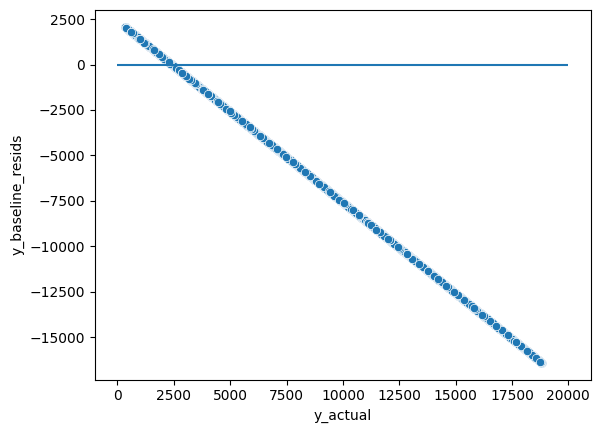

In [21]:
sns.scatterplot(data=preds,x='y_actual', y='y_baseline_resids')
plt.hlines(0,0,20_000)

Now we can square the residuals, to eliminate the differences in the signs. This calculates the squared errors.

In [22]:
preds['y_baseline_resids_sq'] = preds['y_baseline_resids'] ** 2
preds.head()

,y_actual,y_baseline,y_mean,y_baseline_resids,y_baseline_resids_sq
19498,8131,2404.0,3951.495312,-5727.0,32798529.0
31230,756,2404.0,3951.495312,1648.0,2715904.0
22312,10351,2404.0,3951.495312,-7947.0,63154809.0
279,2795,2404.0,3951.495312,-391.0,152881.0
6647,4092,2404.0,3951.495312,-1688.0,2849344.0


We can add all the squared errors together, to calculate the sum of squared errors (SSE). This is the first acronym you encountered in the curriculum.

In [24]:
sse_baseline = preds.y_baseline_resids_sq.sum()
sse_baseline

696475923920.0

The next step is to calculate the mean squared error (MSE). As the name implies, we calculate this value by getting the average of the squared error. We can divide the sum of squared errors (SSE) by the length of the dataframe to calculate this value.

In [25]:
mse_baseline = sse_baseline / len(preds)
mse_baseline

18445784.308490917

Finally, as the name implies, we can calculate the root mean squared error (RMSE) by taking the square root of the mean squared error (MSE). This will return a value that represents the average error in our baseline's predictions in the original units.

In [28]:
rmse_baseline = sqrt(mse_baseline)
rmse_baseline

4294.855563169839

Now that we've done it the long way with the baseline, let's create a basic linear regression model and evaluate it with the help of the sklearn library.

In [29]:
lm = LinearRegression()

lm.fit(X_train, y_train)

preds['y_hat'] = lm.predict(X_train)

In [31]:
rmse_model = sqrt(mean_squared_error(preds.y_actual,preds.y_hat))

In [32]:
rmse_model

1553.8093867380917

Great! We were able to calculate the root mean squared error (RMSE) for our baseline and regression model. Which one performed better?

In [33]:
print(f'RMSE of our baseline: {round(rmse_baseline)}')
print(f'RMSE of our finely tuned model: {round(rmse_model)}')

RMSE of our baseline: 4295
RMSE of our finely tuned model: 1554


<Axes: xlabel='y_actual', ylabel='y_hat_resids'>

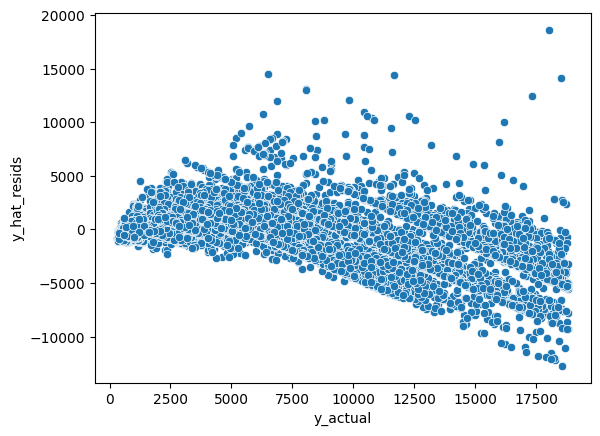

In [36]:
preds['y_hat_resids'] = preds['y_hat'] - preds['y_actual']

sns.scatterplot(data = preds, x= 'y_actual', y= 'y_hat_resids')

Now let's calculate the model significance. This can also be expressed as the R^2 value. The R^2 value equals the explained sum of squares divided by the total sum of squares. The equation with acronyms looks like this: R^2 = ESS / TSS.

The first step is to calculated the explained sum of squares. This is calculated by taking each prediction, subtracting the mean of actual values, squaring it, and adding up all the results. It's very similar to how we calculated the sum of squared errors (SSE).

In [38]:
preds.head(2)

,y_actual,y_baseline,y_mean,y_baseline_resids,y_baseline_resids_sq,y_hat,y_hat_resids
19498,8131,2404.0,3951.495312,-5727.0,32798529.0,7137.116468,-993.883532
31230,756,2404.0,3951.495312,1648.0,2715904.0,148.330012,-607.669988


In [39]:
preds['y_baseline_minus_mean'] = preds['y_baseline'] - preds['y_actual'].mean()
preds.head(2)

,y_actual,y_baseline,y_mean,y_baseline_resids,y_baseline_resids_sq,y_hat,y_hat_resids,y_baseline_minus_mean
19498,8131,2404.0,3951.495312,-5727.0,32798529.0,7137.116468,-993.883532,-1547.495312
31230,756,2404.0,3951.495312,1648.0,2715904.0,148.330012,-607.669988,-1547.495312


In [40]:
ess_baseline = sum(preds.y_baseline_minus_mean ** 2)
ess_baseline

90420658673.29518

Now that we have our explained sum of squares, we have the nominator for our equation. To calculate the denominator, the total sum of squares (TSS), we have to add the sum of squared error (SSE) to the explained sum of squares (ESS).

In [42]:
tss_baseline = sse_baseline + ess_baseline
tss_baseline

786896582593.2952

We have both elements ready! We divide the ESS by the TSS to find the model significance for our baseline.

In [43]:
r_baseline = ess_baseline / tss_baseline
r_baseline

0.11490793158016394

After doing it the long way, let's calculate model significance for our linear regression model using the sklearn library.

In [44]:
preds.head()

,y_actual,y_baseline,y_mean,y_baseline_resids,y_baseline_resids_sq,y_hat,y_hat_resids,y_baseline_minus_mean
19498,8131,2404.0,3951.495312,-5727.0,32798529.0,7137.116468,-993.883532,-1547.495312
31230,756,2404.0,3951.495312,1648.0,2715904.0,148.330012,-607.669988,-1547.495312
22312,10351,2404.0,3951.495312,-7947.0,63154809.0,7137.116468,-3213.883532,-1547.495312
279,2795,2404.0,3951.495312,-391.0,152881.0,4030.989154,1235.989154,-1547.495312
6647,4092,2404.0,3951.495312,-1688.0,2849344.0,3875.682788,-216.317212,-1547.495312


In [45]:
r2_score(preds.y_actual, preds.y_hat)

0.8495846235389342